In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

credits = pd.read_csv('/home/hamza/Downloads/DataSets/tmdb_5000_credits.csv')
movies = pd.read_csv('/home/hamza/Downloads/DataSets/tmdb_5000_movies.csv')

credits.columns = ['id','tittle','cast','crew']

df = movies.merge(credits, on = 'id')

print(df.shape)
print(df.columns)

(4803, 23)
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')


#                                     Demographic Filtering

we will use (weighted rating) witch is counted by the following formula:

    WR = (((v / (v + m))) * R) + (((m / (m + v))) * C)

where:

    v is the number of votes for the movie.
    
    m is the minimum votes required to be listed in the chart.
    
    R is the average rating of the movie.
    
    C is the mean vote across the whole report.

In [2]:
C = df['vote_average'].mean()
R = df['vote_average']
m = df['vote_count'].quantile(0.9)
v = df['vote_count']

In [3]:
q_movies = df[df['vote_count'] >= m]
q_movies.shape

(481, 23)

In [4]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [5]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [6]:
q_movies = q_movies.sort_values('score', ascending = False)
print(q_movies[['title', 'vote_count', 'vote_average', 'score']].head(8))

                         title  vote_count  vote_average     score
1881  The Shawshank Redemption        8205           8.5  8.059258
662                 Fight Club        9413           8.3  7.939256
65             The Dark Knight       12002           8.2  7.920020
3232              Pulp Fiction        8428           8.3  7.904645
96                   Inception       13752           8.1  7.863239
3337             The Godfather        5893           8.4  7.851236
95                Interstellar       10867           8.1  7.809479
809               Forrest Gump        7927           8.2  7.803188


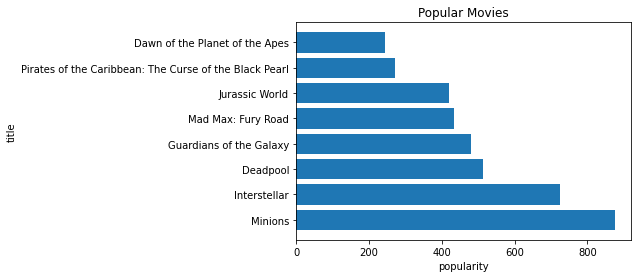

In [7]:
pop = df.sort_values('popularity', ascending = False)
plt.barh(pop['title'].head(8), pop['popularity'].head(8))
plt.title("Popular Movies")
plt.xlabel('popularity')
plt.ylabel('title')
plt.show()

# Content Based Filtering

###                                          by movies Describtions

In [8]:
print(df['overview'].head())

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['overview'] = df['overview'].fillna('')

tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_metrix = tfidf.fit_transform(df['overview']) 

print(tfidf_metrix.shape)

(4803, 20978)


In [10]:
from sklearn.metrics.pairwise import linear_kernel

similar_1 = linear_kernel(tfidf_metrix, tfidf_metrix)

In [11]:
indices = pd.Series(df.index, index = df['title'])

In [12]:
def Get_Recommendations(title, similar):
    
    idx = indices[title]
    sim_movies = list(enumerate(similar[idx]))
    sorted_sim_movies = sorted(sim_movies, key = lambda x: x[1], reverse = True)
    sorted_sim_movies = sorted_sim_movies[1:11]
    movies_indices = [i[0] for i in sorted_sim_movies]
    
    return df['title'].iloc[movies_indices]

In [13]:
Get_Recommendations('The Dark Knight Rises', similar_1)

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [14]:
Get_Recommendations('The Avengers', similar_1)

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

###                  The 3 top actors, the director, related genres and the movie plot keywords.

In [15]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [16]:
def get_director(x):
    
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [17]:
df['director'] = df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(get_list)

In [18]:
df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [19]:
def clean_data(x):
    
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(' ', ''))
    else:
        return ''
        

In [20]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [21]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

df['soup'] = df.apply(create_soup, axis=1)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
cv_metrix = cv.fit_transform(df['soup'])

print(cv_metrix.shape)

(4803, 11520)


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

similar_2 = cosine_similarity(cv_metrix, cv_metrix)

In [24]:
indices = pd.Series(df.index, index = df['title'])

In [25]:
Get_Recommendations('The Dark Knight Rises', similar_2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [26]:
Get_Recommendations('The Godfather', similar_2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

# Collaborative Filtering

In [29]:
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
movies_ratings = pd.read_csv('/home/hamza/Downloads/DataSets/movies_ratings.csv', sep = '\t', names = col_names)

print(movies_ratings.head())

   user_id  item_id  rating  timestamp
0        0       50       5  881250949
1        0      172       5  881250949
2        0      133       1  881250949
3      196      242       3  881250949
4      186      302       3  891717742


In [30]:
movies_id_title = pd.read_csv('/home/hamza/Downloads/DataSets/movies_id_title.csv')

print(movies_id_title.head())

   item_id              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)


In [49]:
df = pd.merge(movies_ratings, movies_id_title, on = 'item_id')

print(df.head())

   user_id  item_id  rating  timestamp             title
0        0       50       5  881250949  Star Wars (1977)
1      290       50       5  880473582  Star Wars (1977)
2       79       50       4  891271545  Star Wars (1977)
3        2       50       5  888552084  Star Wars (1977)
4        8       50       5  879362124  Star Wars (1977)


In [50]:
print(df.groupby('title')['rating'].mean().sort_values(ascending = False).head())

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64


In [51]:
print(df.groupby('title')['rating'].count().sort_values(ascending = False).head())

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64


In [52]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num_ratings'] = df.groupby('title')['rating'].count()

print(ratings)

                                         rating  num_ratings
title                                                       
'Til There Was You (1997)              2.333333            9
1-900 (1994)                           2.600000            5
101 Dalmatians (1996)                  2.908257          109
12 Angry Men (1957)                    4.344000          125
187 (1997)                             3.024390           41
...                                         ...          ...
Young Guns II (1990)                   2.772727           44
Young Poisoner's Handbook, The (1995)  3.341463           41
Zeus and Roxanne (1997)                2.166667            6
unknown                                3.444444            9
Á köldum klaka (Cold Fever) (1994)     3.000000            1

[1664 rows x 2 columns]


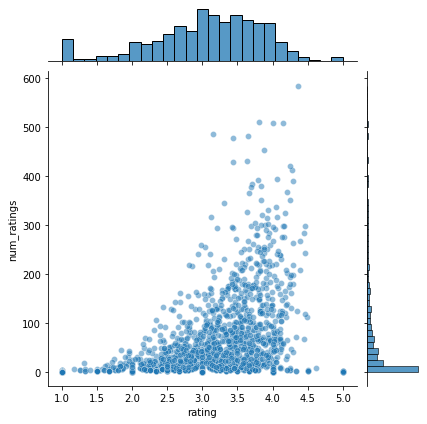

In [53]:
sns.jointplot(x = 'rating', y = 'num_ratings', data = ratings, alpha = 0.5)

In [57]:
movies_pivot = df.pivot_table(index = 'user_id', columns = 'title', values = 'rating')

print(movies_pivot.head(3))

title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
0                              NaN           NaN                    NaN   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                 
0                        NaN         NaN                          NaN   
1                        5.0         NaN                          NaN   
2                        NaN         NaN                          NaN   

title    20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
user_id                                                                      
0                                        NaN                           NaN   
1                       

In [58]:
print(ratings.sort_values('num_ratings', ascending = False))

                                      rating  num_ratings
title                                                    
Star Wars (1977)                    4.359589          584
Contact (1997)                      3.803536          509
Fargo (1996)                        4.155512          508
Return of the Jedi (1983)           4.007890          507
Liar Liar (1997)                    3.156701          485
...                                      ...          ...
Great Day in Harlem, A (1994)       5.000000            1
Other Voices, Other Rooms (1997)    3.000000            1
Good Morning (1971)                 1.000000            1
Girls Town (1996)                   3.000000            1
Á köldum klaka (Cold Fever) (1994)  3.000000            1

[1664 rows x 2 columns]


In [61]:
star_wars_ratings = movies_pivot['Star Wars (1977)']

print(star_wars_ratings.head())

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64


In [62]:
corr_with_star_sars = movies_pivot.corrwith(star_wars_ratings)

corr_star_wars = pd.DataFrame(corr_with_star_sars, columns = ['Correlation'])
corr_star_wars.dropna(inplace = True)
print(corr_star_wars.head())

                           Correlation
title                                 
'Til There Was You (1997)     0.872872
1-900 (1994)                 -0.645497
101 Dalmatians (1996)         0.211132
12 Angry Men (1957)           0.184289
187 (1997)                    0.027398


In [65]:
print(corr_star_wars.sort_values('Correlation', ascending = False).head())

                     Correlation
title                           
Hollow Reed (1996)           1.0
Commandments (1997)          1.0
Cosi (1996)                  1.0
No Escape (1994)             1.0
Stripes (1981)               1.0


In [66]:
corr_star_wars = corr_star_wars.join(ratings['num_ratings'])

print(corr_star_wars.head())

                           Correlation  num_ratings
title                                              
'Til There Was You (1997)     0.872872            9
1-900 (1994)                 -0.645497            5
101 Dalmatians (1996)         0.211132          109
12 Angry Men (1957)           0.184289          125
187 (1997)                    0.027398           41


In [67]:
print(corr_star_wars[corr_star_wars['num_ratings'] > 100].sort_values('Correlation', ascending = False).head())

                                                    Correlation  num_ratings
title                                                                       
Star Wars (1977)                                       1.000000          584
Empire Strikes Back, The (1980)                        0.748353          368
Return of the Jedi (1983)                              0.672556          507
Raiders of the Lost Ark (1981)                         0.536117          420
Austin Powers: International Man of Mystery (1997)     0.377433          130


### Now we can difine a function that take (movie title) and return (next recommendation) based on ratings

In [86]:
def Get_Recommendations_rating(title):
    movies_pivot = df.pivot_table(index = 'user_id', columns = 'title', values = 'rating')
    title_ratings = movies_pivot[title]
    title_corr = movies_pivot.corrwith(title_ratings)
    
    df_corr = pd.DataFrame(title_corr, columns = ['Correlation'])
    df_corr = df_corr.join(ratings['num_ratings'])
    
    return df_corr[df_corr['num_ratings'] > 100].sort_values('Correlation', ascending = False).head()

In [87]:
Get_Recommendations_rating('Star Wars (1977)')

,Correlation,num_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


In [88]:
Get_Recommendations_rating('Liar Liar (1997)')

,Correlation,num_ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
